In [221]:
from fredapi import Fred
import pandas as pd
import numpy as np
import os

First we should define the problem: We are going to attempt to predict the price of VTI.

# Check training data

Before we train our model we need to investigate the data. First we should ensure that all of the data is feeding through and address any null values.

In [222]:
raw_data = pd.read_csv(os.path.join('data','dataset_raw.csv'))
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data.set_index(keys='date', inplace=True, drop=True, verify_integrity=True)
raw_data['month'] = raw_data.index.month
raw_data['weekday'] = raw_data.index.weekday
raw_data['quarter'] = raw_data.index.quarter
raw_data['week'] = raw_data.index.week
raw_data.head()

/var/folders/5x/z5qbg5w927vg45mvfkfy9k5c0000gn/T/ipykernel_2646/3041991373.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  raw_data['week'] = raw_data.index.week


,t10y2y,dff,bamlh0a0hym2,sp500,bamlh0a0hym2ey,dcoilwtico,dtwexbgs,vixcls,djia,nasdaqcom,t10y3m,month,weekday,quarter,week
date,,,,,,,,,,,,,,,
1900-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,1
1900-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1
1900-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,1,1
1900-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,1,1
1900-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4,1,1


In [223]:
import seaborn as sns

<AxesSubplot: ylabel='date'>

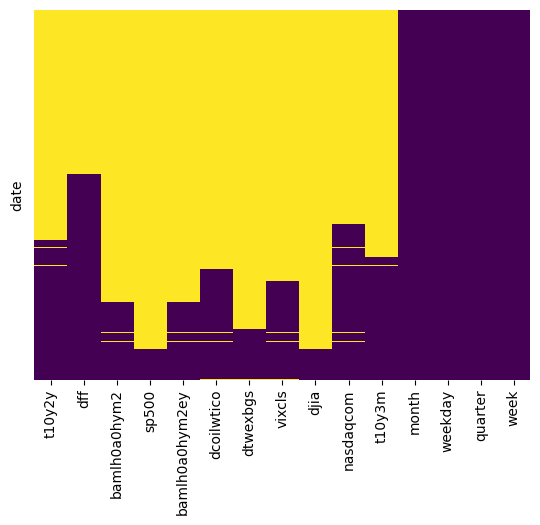

In [224]:
sns.heatmap(raw_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Since we're missing so many values for the S&P 500 and the Dow Jones, we will drop those columns and reassess based on the data available to us. 

In [225]:
raw_data.drop(columns=['sp500','djia','dtwexbgs'],inplace=True)

<AxesSubplot: ylabel='date'>

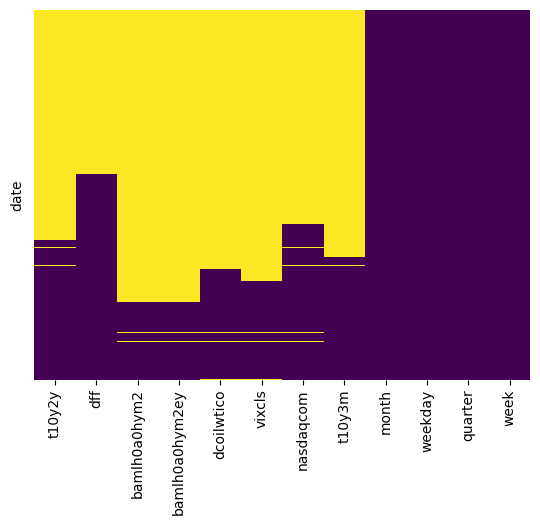

In [226]:
sns.heatmap(raw_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

There are certain holidays that we will not remove by removing weekends. In this case, we will just drop those values. An alternative might be forward filling the values, but since we can't make a decision on the holidays any way, if we duplicate those values we will overweight them during training. 

In [227]:
raw_data = raw_data.dropna(how='any',axis=0)

<AxesSubplot: ylabel='date'>

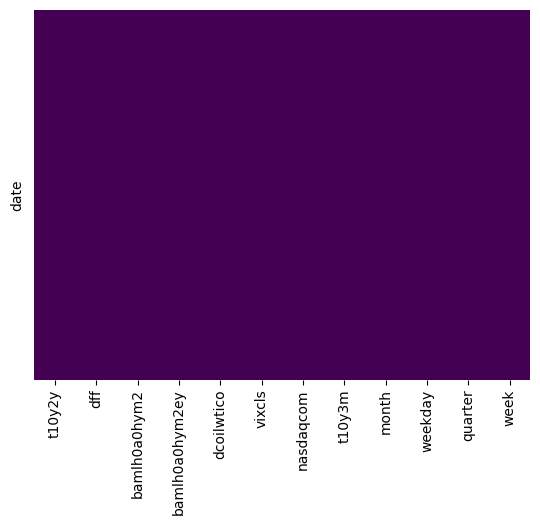

In [228]:
sns.heatmap(raw_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Now that we have the above solid square (there are no null values, we can begin to work with the data). Next, we'll capture some summary stats to determine more things about the dataset.

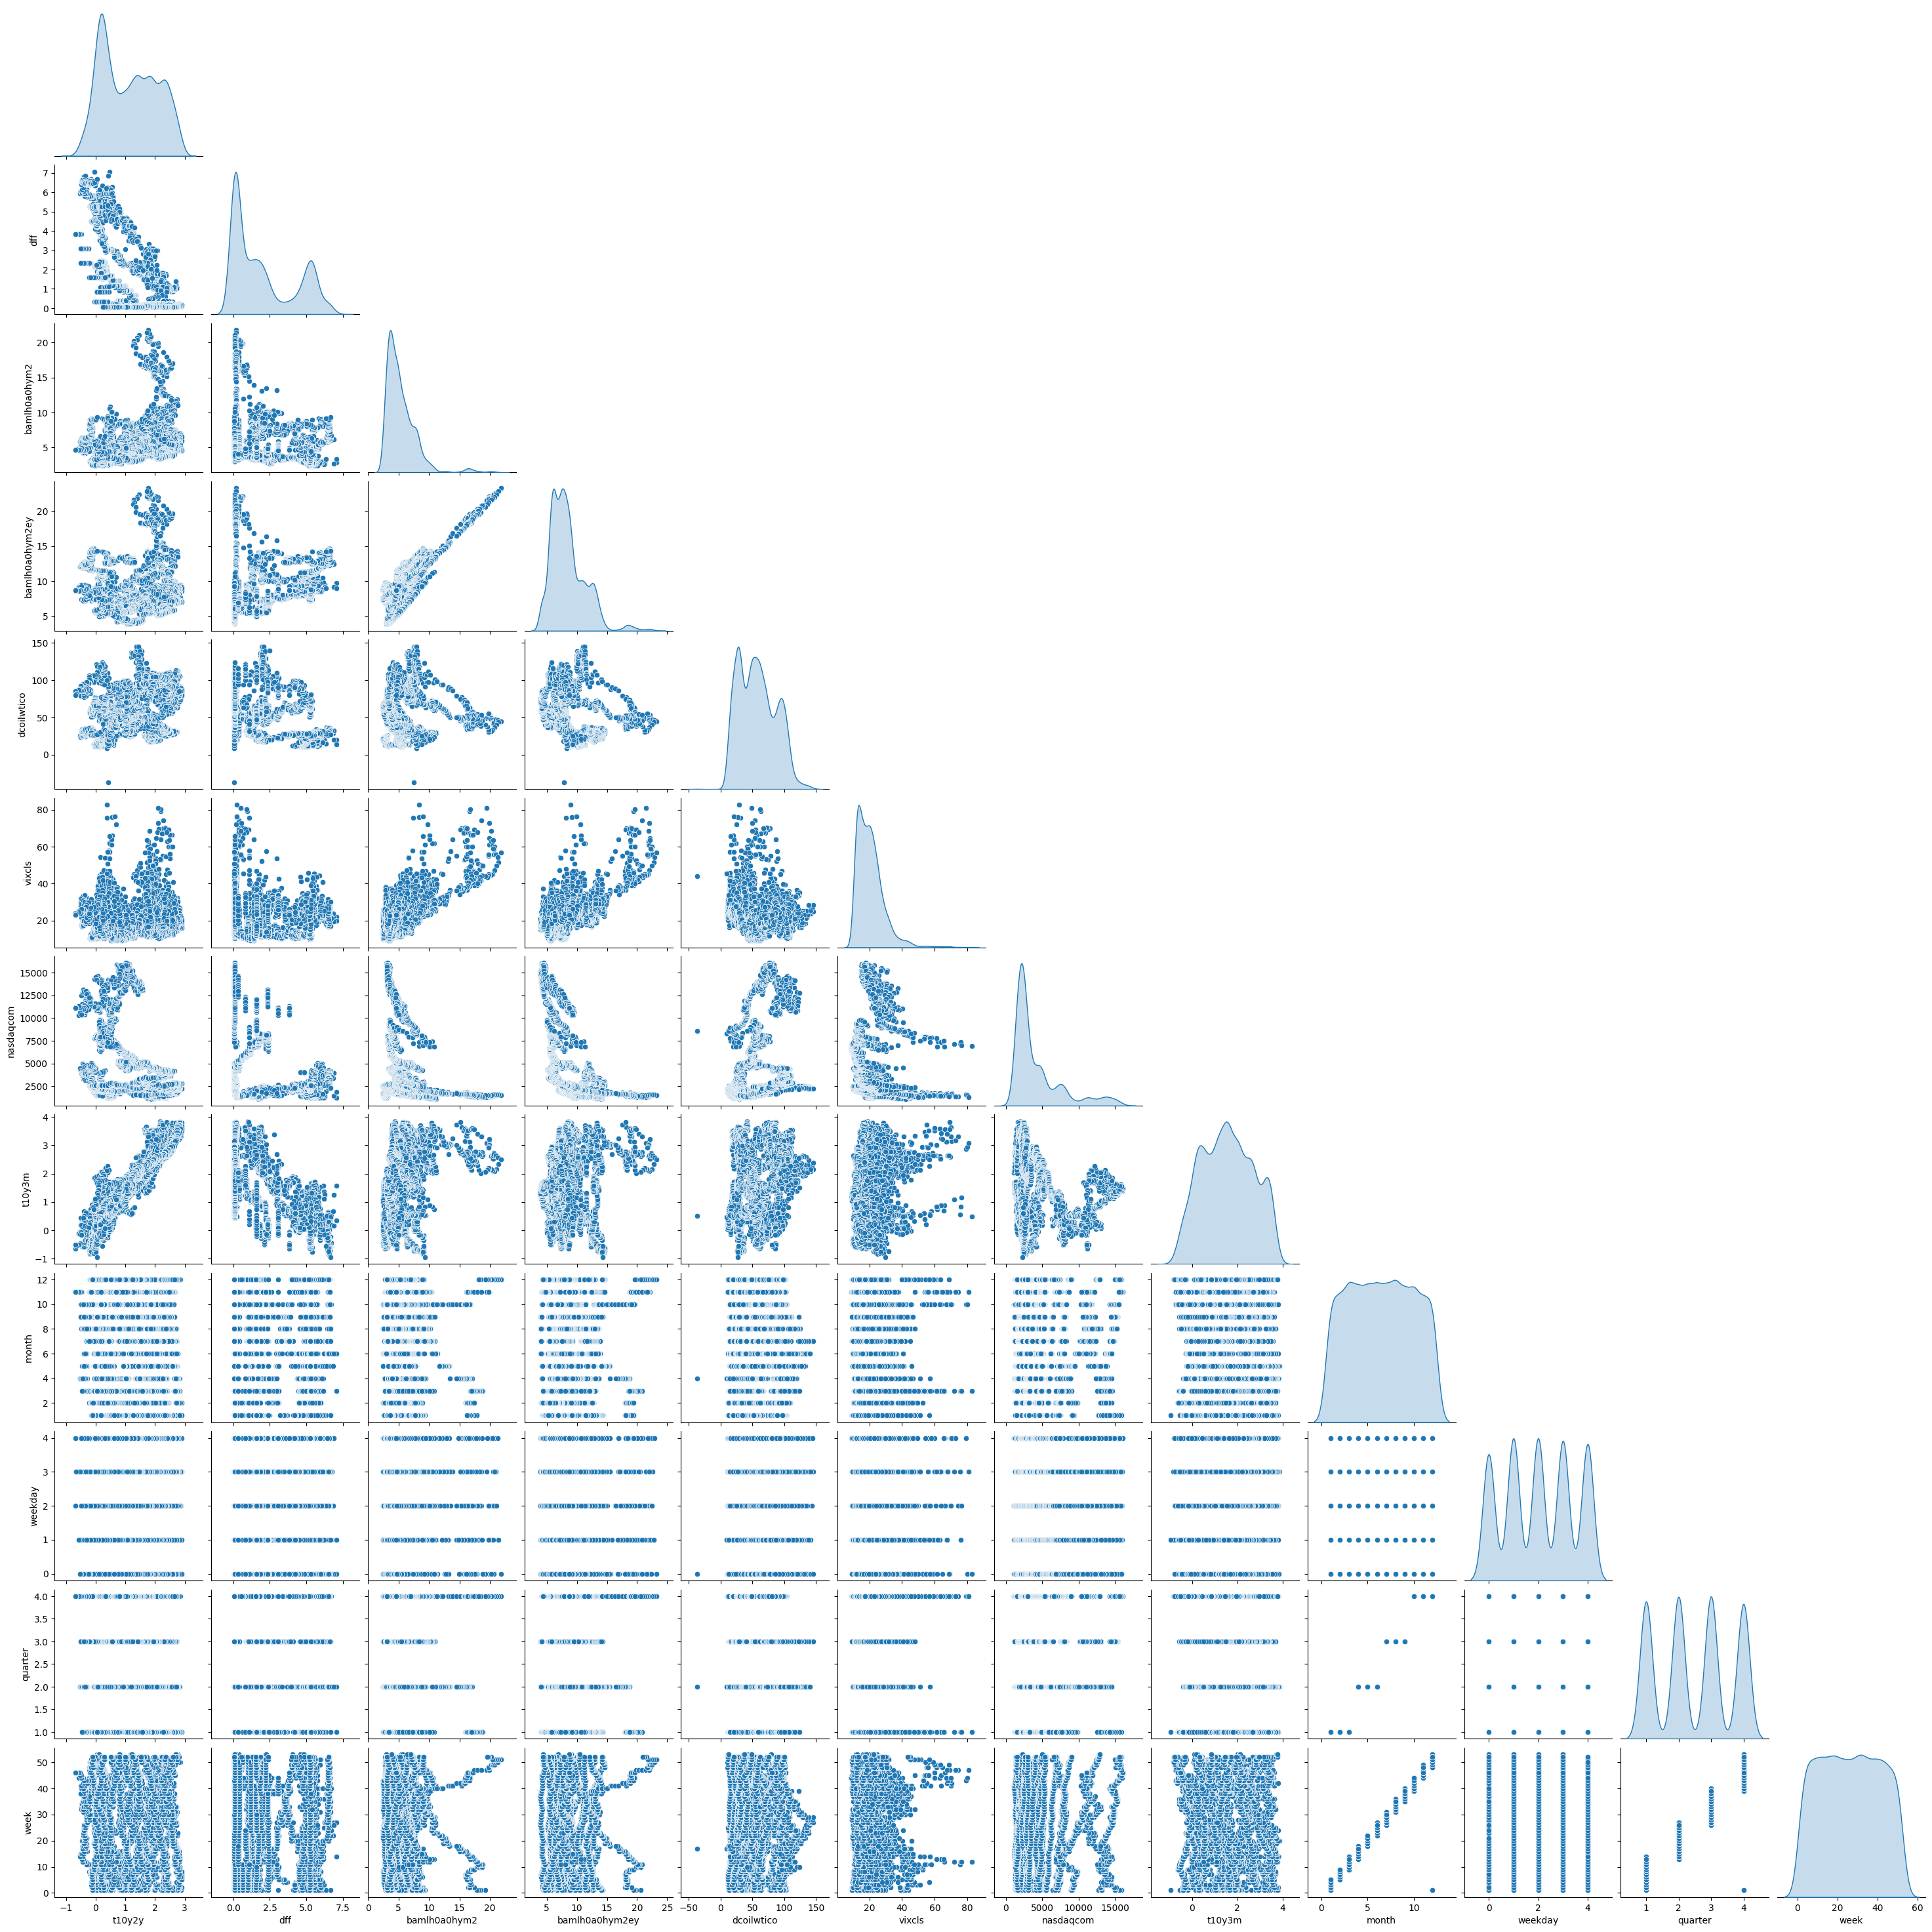

In [229]:
sns.pairplot(data=raw_data,diag_kind='kde',corner=True)

All of our variables are values which makes them easy to work with. Each dot represents a value. A couple things of note, the DFF (Federal Funds Rate) is constant for much of the time. Other than that, no patterns immediately jump out. 

We should also note that some variables that are index levels should be converted to the natural logarithm to account for power laws. We should also probably consider the percent changes of the variables as well. 

<AxesSubplot: >

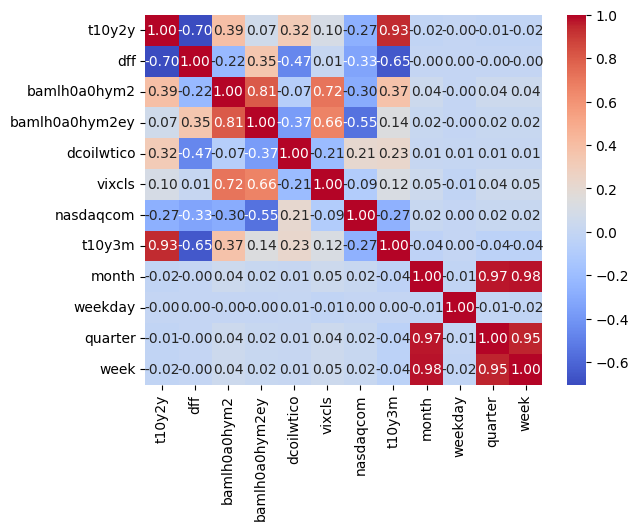

In [230]:
sns.heatmap(raw_data.corr(),annot=True,fmt='.2f',linewidth=.001,cbar=True,cmap='coolwarm')

Additionally, when we look at correlations to see which values are repeated, we notice that the 10 year treasury minus the 2 year treasury is highly correlated to the 10 year treasury minus the 3 month treasury. This isn't surprising, but high correlations are candidates for exclusion because high correlations imply that information is repeated across the data set. All things being equal, it would be better to drop this information in exchange for an easier data set to work with. We will drop the 10 year minus the 2 year as the 10 year minus the 3 month has been more robust in recession prediction. 

We will also drop the series BAMLH0A0HYM2EY because it is highly correlated to the series BAMLH0A0HYM2. We want to use BAMLH0A0HYM2 because this is the OAS (Option Adjusted Spread) which accounts for the fact that some fixed income instruments have embedded options which impact the pricing of them and thus the spread.

In [231]:
raw_data = raw_data.drop(columns=['t10y2y','bamlh0a0hym2ey']).copy()
raw_data.head()

,dff,bamlh0a0hym2,dcoilwtico,vixcls,nasdaqcom,t10y3m,month,weekday,quarter,week
date,,,,,,,,,,
1996-12-31,6.26,3.13,25.90,20.92,1291.03,1.22,12,1,4,1
1997-01-02,5.79,3.06,25.55,21.14,1280.70,1.35,1,3,1,1
1997-01-03,5.17,3.09,25.55,19.13,1310.68,1.35,1,4,1,1
1997-01-06,5.26,3.10,26.25,19.89,1316.40,1.37,1,0,1,2
1997-01-07,5.20,3.10,26.25,19.35,1327.73,1.41,1,1,1,2


<AxesSubplot: >

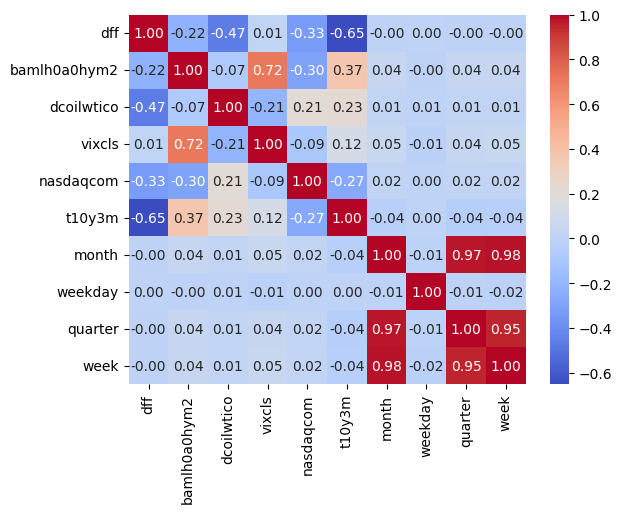

In [232]:
sns.heatmap(raw_data.corr(),annot=True,fmt='.2f',linewidth=.001,cbar=True,cmap='coolwarm')

Now, we are working with a dataset we can start to use an estimator on. 

In [233]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6439 entries, 1996-12-31 to 2022-11-18
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dff           6439 non-null   float64
 1   bamlh0a0hym2  6439 non-null   float64
 2   dcoilwtico    6439 non-null   float64
 3   vixcls        6439 non-null   float64
 4   nasdaqcom     6439 non-null   float64
 5   t10y3m        6439 non-null   float64
 6   month         6439 non-null   int64  
 7   weekday       6439 non-null   int64  
 8   quarter       6439 non-null   int64  
 9   week          6439 non-null   int64  
dtypes: float64(6), int64(4)
memory usage: 553.4 KB


In [234]:
raw_data.describe()

,dff,bamlh0a0hym2,dcoilwtico,vixcls,nasdaqcom,t10y3m,month,weekday,quarter,week
count,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000
mean,2.055655,5.417226,57.392423,20.624075,4286.899479,1.564572,6.484392,2.025936,2.493555,26.387327
std,2.113670,2.598458,28.493112,8.460621,3414.863706,1.120600,3.407824,1.392892,1.108265,14.871867
min,0.040000,2.410000,-36.980000,9.140000,1114.110000,-0.950000,1.000000,0.000000,1.000000,1.000000
25%,0.140000,3.670000,31.505000,14.440000,2050.955000,0.630000,4.000000,1.000000,2.000000,14.000000
50%,1.260000,4.760000,55.030000,19.220000,2698.300000,1.550000,6.000000,2.000000,2.000000,26.000000
75%,4.090000,6.410000,78.950000,24.350000,5099.085000,2.460000,9.000000,3.000000,3.000000,39.000000
max,7.070000,21.820000,145.310000,82.690000,16057.440000,3.850000,12.000000,4.000000,4.000000,53.000000


# Feature engineering

We will use the TA (technical analysis) library in order to add some features to our data set for use. We will add Aroon indicators to determine potential changes in trends and an exponential moving average. 

In [235]:
import ta

In [236]:
columns_to_make_technical_indicators_from = [col for col in raw_data.columns]
columns_to_make_technical_indicators_from

['dff',
 'bamlh0a0hym2',
 'dcoilwtico',
 'vixcls',
 'nasdaqcom',
 't10y3m',
 'month',
 'weekday',
 'quarter',
 'week']

In [237]:
for technical_analysis_column in columns_to_make_technical_indicators_from:
    raw_data[technical_analysis_column+'_aroon_indicator'] = ta.trend.AroonIndicator(raw_data[technical_analysis_column],window=14).aroon_indicator()
    raw_data[technical_analysis_column+'_ema_indicator'] = ta.trend.EMAIndicator(raw_data[technical_analysis_column],window=14).ema_indicator()
    raw_data[technical_analysis_column+'_macd_diff'] = ta.trend.MACD(raw_data[technical_analysis_column],window_slow=26,window_fast=12,window_sign=9).macd_diff()
    raw_data[technical_analysis_column+'_trix'] = ta.trend.TRIXIndicator(raw_data[technical_analysis_column],window=14).trix()
    raw_data[technical_analysis_column+'_sma_26'] = ta.trend.SMAIndicator(raw_data[technical_analysis_column],window=26).sma_indicator()
    raw_data[technical_analysis_column+'_sma_12'] = ta.trend.SMAIndicator(raw_data[technical_analysis_column],window=12).sma_indicator()
    raw_data[technical_analysis_column+'_sma_9'] = ta.trend.SMAIndicator(raw_data[technical_analysis_column],window=9).sma_indicator()
    if technical_analysis_column == 'nasdaqcom':
        raw_data[technical_analysis_column+'_log'] = np.log(raw_data[technical_analysis_column])
    else:
        raw_data[technical_analysis_column+'_diff'] = raw_data[technical_analysis_column].diff()

raw_data.head()

,dff,bamlh0a0hym2,dcoilwtico,vixcls,nasdaqcom,t10y3m,month,weekday,quarter,week,...,quarter_sma_9,quarter_diff,week_aroon_indicator,week_ema_indicator,week_macd_diff,week_trix,week_sma_26,week_sma_12,week_sma_9,week_diff
date,,,,,,,,,,,,,,,,,,,,,
1996-12-31,6.26,3.13,25.90,20.92,1291.03,1.22,12,1,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-01-02,5.79,3.06,25.55,21.14,1280.70,1.35,1,3,1,1,...,NaN,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1997-01-03,5.17,3.09,25.55,19.13,1310.68,1.35,1,4,1,1,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1997-01-06,5.26,3.10,26.25,19.89,1316.40,1.37,1,0,1,2,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1997-01-07,5.20,3.10,26.25,19.35,1327.73,1.41,1,1,1,2,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Oh no, we have some nulls, lets figure out if they are an issue. 

<AxesSubplot: ylabel='date'>

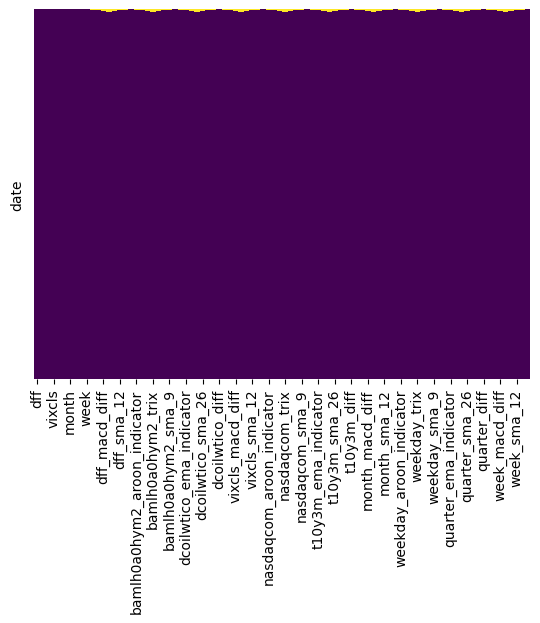

In [238]:
sns.heatmap(raw_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

It looks like dropping these nulls will not cause a problem. 

In [239]:
raw_data = raw_data.dropna(how='any',axis=0)
raw_data.head()

,dff,bamlh0a0hym2,dcoilwtico,vixcls,nasdaqcom,t10y3m,month,weekday,quarter,week,...,quarter_sma_9,quarter_diff,week_aroon_indicator,week_ema_indicator,week_macd_diff,week_trix,week_sma_26,week_sma_12,week_sma_9,week_diff
date,,,,,,,,,,,,,,,,,,,,,
1997-03-03,5.40,2.71,20.25,20.89,1311.18,1.34,3,0,1,10,...,1.0,0.0,92.857143,8.232790,0.054869,3.190755,6.923077,8.416667,8.777778,1.0
1997-03-04,5.16,2.67,20.75,20.62,1317.37,1.35,3,1,1,10,...,1.0,0.0,85.714286,8.468418,0.059730,3.181591,7.153846,8.666667,9.000000,0.0
1997-03-05,5.15,2.71,20.50,19.49,1329.09,1.39,3,2,1,10,...,1.0,0.0,78.571429,8.672629,0.047212,3.155444,7.384615,8.916667,9.222222,0.0
1997-03-06,5.22,2.70,21.00,20.48,1315.43,1.39,3,3,1,10,...,1.0,0.0,71.428571,8.849612,0.024351,3.108711,7.576923,9.083333,9.444444,0.0
1997-03-07,5.21,2.74,21.35,19.32,1311.80,1.35,3,4,1,10,...,1.0,0.0,64.285714,9.002997,-0.003851,3.041173,7.769231,9.250000,9.555556,0.0


# Problem setup

Now we are going to try to predict something investible. We will try to predict buy and sell days for the NASDAQ. We will need to establish our y variable = target variable = dependent variable. 

In [240]:
number_of_days_in_the_future_to_predict = 1

raw_data['nasdaqcom_next_day'] = (raw_data['nasdaqcom'].shift(-number_of_days_in_the_future_to_predict)/raw_data['nasdaqcom'])-1
raw_data['buy_sell_signal'] = np.where(raw_data['nasdaqcom_next_day']>0,1,0)
raw_data.drop(columns=['nasdaqcom_next_day'],inplace=True)

raw_data = raw_data.iloc[:-number_of_days_in_the_future_to_predict,:]

raw_data[['nasdaqcom','buy_sell_signal']].tail(30)

,nasdaqcom,buy_sell_signal
date,,
2022-10-05,11148.64,0
2022-10-06,11073.31,0
2022-10-07,10652.40,0
2022-10-11,10426.19,0
2022-10-12,10417.10,1
2022-10-13,10649.15,0
2022-10-14,10321.39,1
2022-10-17,10675.80,1
2022-10-18,10772.40,0


Next we check that the above is correct. There are also some issues with using the NASDAQ in our dataset, and so I will be dropping it. 

In [241]:
nasdaq_data = raw_data['nasdaqcom'].copy()
raw_data.drop(columns=['nasdaqcom'],inplace=True)

# Training/validation/test split

Now we need to intelligently split the dataset since this is a time series. We need to ensure that the data that our model is trained on is not in any way exposed to our testing data set, otherwise we will be testing the accuracy of a model that knew the outcomes of our training data. 

In [242]:
from sklearn.model_selection import train_test_split

In [243]:
target = 'buy_sell_signal'
features = [x for x in list(raw_data.columns) if x != target]

y = raw_data[target]
x = raw_data[features]

In [244]:
print(x.shape)
print(y.shape)

(6398, 89)
(6398,)


Turning shuffle to false means that we will hold out the last 15% of the dataset for testing at the very end of the cross validation. 

In [245]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42, shuffle=False)

## Feature importance with random variable selection

In [246]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn import metrics
import time
import itertools

Here I'd just like to demonstrate that this is a random process. If we were able to accurately predict the next close of the stock market then the random variable would not be the most important variable in the dataset. 

In [247]:
from sklearn.preprocessing import PolynomialFeatures

rfc_rand = RandomForestClassifier()

x_train_rand = x_train.copy()
y_train_rand = y_train.copy()

x_train_rand['rand_var'] = np.random.uniform(0,1,size=int(len(x_train_rand)))

rfc_rand.fit(x_train_rand, y_train_rand)
feature_imp = rfc_rand.feature_importances_

feature_df = pd.DataFrame({'feature':x_train_rand.columns,'importance':feature_imp})
feature_df.sort_values(by='importance',ascending=False,inplace=True)
feature_df.head(10)

,feature,importance
89,rand_var,0.022101
67,weekday_macd_diff,0.020668
40,vixcls_diff,0.020532
32,dcoilwtico_diff,0.020326
43,nasdaqcom_macd_diff,0.018937
66,weekday_ema_indicator,0.018623
68,weekday_trix,0.018424
51,t10y3m_macd_diff,0.018050
35,vixcls_macd_diff,0.016999
27,dcoilwtico_macd_diff,0.016704


# Training

We are going to use a random forest classifier to predict the next day's values either being above or below the current values. We will perform cross validation on this to tune our hyperparameters to optimize our model. 

First we are going to set up the parameter grid. Below is a list of parameters for us to use to test our random forest model. 

Below are the final columns:

In [248]:
print(list(x_train.columns))

['dff', 'bamlh0a0hym2', 'dcoilwtico', 'vixcls', 't10y3m', 'month', 'weekday', 'quarter', 'week', 'dff_aroon_indicator', 'dff_ema_indicator', 'dff_macd_diff', 'dff_trix', 'dff_sma_26', 'dff_sma_12', 'dff_sma_9', 'dff_diff', 'bamlh0a0hym2_aroon_indicator', 'bamlh0a0hym2_ema_indicator', 'bamlh0a0hym2_macd_diff', 'bamlh0a0hym2_trix', 'bamlh0a0hym2_sma_26', 'bamlh0a0hym2_sma_12', 'bamlh0a0hym2_sma_9', 'bamlh0a0hym2_diff', 'dcoilwtico_aroon_indicator', 'dcoilwtico_ema_indicator', 'dcoilwtico_macd_diff', 'dcoilwtico_trix', 'dcoilwtico_sma_26', 'dcoilwtico_sma_12', 'dcoilwtico_sma_9', 'dcoilwtico_diff', 'vixcls_aroon_indicator', 'vixcls_ema_indicator', 'vixcls_macd_diff', 'vixcls_trix', 'vixcls_sma_26', 'vixcls_sma_12', 'vixcls_sma_9', 'vixcls_diff', 'nasdaqcom_aroon_indicator', 'nasdaqcom_ema_indicator', 'nasdaqcom_macd_diff', 'nasdaqcom_trix', 'nasdaqcom_sma_26', 'nasdaqcom_sma_12', 'nasdaqcom_sma_9', 'nasdaqcom_log', 't10y3m_aroon_indicator', 't10y3m_ema_indicator', 't10y3m_macd_diff', 't10

In [249]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]
# Number of features to consider at every split
max_features = ['sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
             }

In [250]:
number_of_splits = 5
tscv = TimeSeriesSplit(max_train_size=None, n_splits=number_of_splits,gap=5)

rfc = RandomForestClassifier()

keys, values = zip(*param_grid.items())
test_grids = [dict(zip(keys, v)) for v in itertools.product(*values)]
print('The number of test grids to run is: ',len(test_grids))
print('The number of test grids and splits is ',len(test_grids)*number_of_splits)
results_df = pd.DataFrame()

number_of_required_runs = len(test_grids)*number_of_splits
total_run_counter = 0
start_time = time.time()

for test_grid in test_grids:
    benchmark_scores = []
    i = 0
    for train_index, validate_index in tscv.split(x_train):
        x_cv_train, x_cv_test = x_train.iloc[train_index].copy(), x_train.iloc[validate_index].copy()
        y_cv_train, y_cv_test = y_train.iloc[train_index].copy(), y_train.iloc[validate_index].copy()

        current_elapsed_time = time.time() - start_time
        print('Running the CV fold: ',i+1,' of ',number_of_splits,' | Percentage of runs completed: ',round((total_run_counter/number_of_required_runs)*100,2),'%', ' | Elapsed time: ',round(current_elapsed_time,2),' seconds','\nEstimated time remaining: ',round((current_elapsed_time/(total_run_counter+1))*(number_of_required_runs-total_run_counter),2),' seconds','\nCV training x and y set extends from {} to {}'.format(x_cv_train.index[0],x_cv_train.index[-1]),'\nCV testing x and y set extends from {} to {}'.format(x_cv_test.index[0],x_cv_test.index[-1]))
        i+=1

        rfc_clone = clone(rfc)
        rfc_clone.set_params(**test_grid)
        rfc_clone.fit(x_cv_train, y_cv_train)
        validation_predictions = rfc_clone.predict(x_cv_test)
        benchmark_score = metrics.f1_score(y_cv_test, validation_predictions)
        print('The benchmark score for this CV fold is: ',benchmark_score)
        benchmark_scores.append(benchmark_score)
        total_run_counter += 1

    average_benchmark_score = sum(benchmark_scores)/len(benchmark_scores)
    test_grid['Average Score'] = average_benchmark_score
    print('The average benchmark score for this test grid is: ',average_benchmark_score)
    results_df = pd.concat([pd.DataFrame(test_grid, index=[0]), results_df], axis=0)

results_df.sort_values(by='Average Score', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)
    

The number of test grids to run is:  8
The number of test grids and splits is  40
Running the CV fold:  1  of  5  | Percentage of runs completed:  0.0 %  | Elapsed time:  0.0  seconds 
Estimated time remaining:  0.07  seconds 
CV training x and y set extends from 1997-03-03 00:00:00 to 2000-10-16 00:00:00 
CV testing x and y set extends from 2000-10-24 00:00:00 to 2004-06-24 00:00:00
The benchmark score for this CV fold is:  0.5708661417322834
Running the CV fold:  2  of  5  | Percentage of runs completed:  2.5 %  | Elapsed time:  0.28  seconds 
Estimated time remaining:  5.53  seconds 
CV training x and y set extends from 1997-03-03 00:00:00 to 2004-06-17 00:00:00 
CV testing x and y set extends from 2004-06-25 00:00:00 to 2008-02-15 00:00:00
The benchmark score for this CV fold is:  0.25656877897990726
Running the CV fold:  3  of  5  | Percentage of runs completed:  5.0 %  | Elapsed time:  0.88  seconds 
Estimated time remaining:  11.13  seconds 
CV training x and y set extends from 

In [251]:
results_df.head(10)

,max_features,min_samples_split,min_samples_leaf,Average Score
0,log2,5,2,0.458725
1,sqrt,5,2,0.433704
2,sqrt,2,2,0.430316
3,sqrt,5,1,0.426154
4,log2,2,2,0.425903
5,sqrt,2,1,0.401097
6,log2,2,1,0.396258
7,log2,5,1,0.382086


In [252]:
print('The best test grid is: \n',results_df.iloc[0,:])

The best test grid is: 
 max_features             log2
min_samples_split           5
min_samples_leaf            2
Average Score        0.458725
Name: 0, dtype: object


In [253]:
best_params = results_df.iloc[0,:-1].to_dict()

# Training final model

In [254]:
print(list(x_train.columns))

['dff', 'bamlh0a0hym2', 'dcoilwtico', 'vixcls', 't10y3m', 'month', 'weekday', 'quarter', 'week', 'dff_aroon_indicator', 'dff_ema_indicator', 'dff_macd_diff', 'dff_trix', 'dff_sma_26', 'dff_sma_12', 'dff_sma_9', 'dff_diff', 'bamlh0a0hym2_aroon_indicator', 'bamlh0a0hym2_ema_indicator', 'bamlh0a0hym2_macd_diff', 'bamlh0a0hym2_trix', 'bamlh0a0hym2_sma_26', 'bamlh0a0hym2_sma_12', 'bamlh0a0hym2_sma_9', 'bamlh0a0hym2_diff', 'dcoilwtico_aroon_indicator', 'dcoilwtico_ema_indicator', 'dcoilwtico_macd_diff', 'dcoilwtico_trix', 'dcoilwtico_sma_26', 'dcoilwtico_sma_12', 'dcoilwtico_sma_9', 'dcoilwtico_diff', 'vixcls_aroon_indicator', 'vixcls_ema_indicator', 'vixcls_macd_diff', 'vixcls_trix', 'vixcls_sma_26', 'vixcls_sma_12', 'vixcls_sma_9', 'vixcls_diff', 'nasdaqcom_aroon_indicator', 'nasdaqcom_ema_indicator', 'nasdaqcom_macd_diff', 'nasdaqcom_trix', 'nasdaqcom_sma_26', 'nasdaqcom_sma_12', 'nasdaqcom_sma_9', 'nasdaqcom_log', 't10y3m_aroon_indicator', 't10y3m_ema_indicator', 't10y3m_macd_diff', 't10

In [255]:
rfc_final = RandomForestClassifier()
rfc_final.set_params(**best_params)
rfc_final.fit(x_train, y_train)
final_predictions = rfc_final.predict(x_test)
final_score = metrics.f1_score(y_test, final_predictions)
print('The final F1 score is: ',final_score)

The final F1 score is:  0.4240282685512367


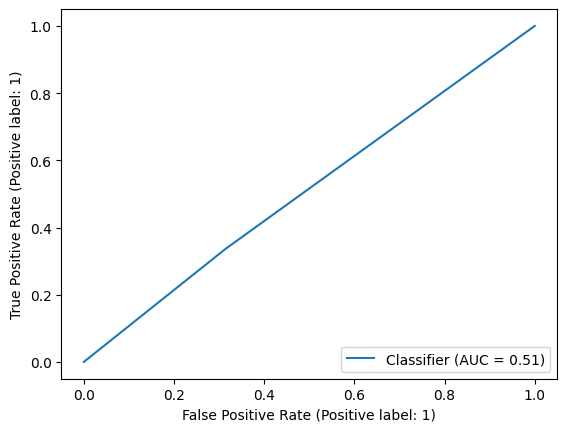

In [256]:
metrics.RocCurveDisplay.from_predictions(y_test,final_predictions)

In [257]:
print(metrics.classification_report(y_test,final_predictions))

              precision    recall  f1-score   support

           0       0.45      0.69      0.54       424
           1       0.58      0.34      0.42       536

    accuracy                           0.49       960
   macro avg       0.51      0.51      0.48       960
weighted avg       0.52      0.49      0.48       960



# Backtest

In [258]:
final_data_backtest = pd.DataFrame(data=y_test)
final_data_backtest['predictions'] = final_predictions
final_data_backtest

,buy_sell_signal,predictions
date,,
2019-01-14,1,0
2019-01-15,1,0
2019-01-16,1,0
2019-01-17,1,0
2019-01-18,0,0
...,...,...
2022-11-10,1,0
2022-11-14,1,0
2022-11-15,0,0


In [259]:
final_data_backtest = final_data_backtest.merge(nasdaq_data, how='left', left_index=True, right_index=True)
final_data_backtest

,buy_sell_signal,predictions,nasdaqcom
date,,,
2019-01-14,1,0,6905.914
2019-01-15,1,0,7023.836
2019-01-16,1,0,7034.691
2019-01-17,1,0,7084.465
2019-01-18,0,0,7157.227
...,...,...,...
2022-11-10,1,0,11114.150
2022-11-14,1,0,11196.220
2022-11-15,0,0,11358.410


In [260]:
final_data_backtest['percent_change'] = final_data_backtest['nasdaqcom'].pct_change()
final_data_backtest

,buy_sell_signal,predictions,nasdaqcom,percent_change
date,,,,
2019-01-14,1,0,6905.914,NaN
2019-01-15,1,0,7023.836,0.017076
2019-01-16,1,0,7034.691,0.001545
2019-01-17,1,0,7084.465,0.007076
2019-01-18,0,0,7157.227,0.010271
...,...,...,...,...
2022-11-10,1,0,11114.150,0.073502
2022-11-14,1,0,11196.220,0.007384
2022-11-15,0,0,11358.410,0.014486


In [261]:
final_data_backtest['actual_experience_based_on_model'] = np.where(final_data_backtest['predictions']==1,final_data_backtest['percent_change']+1,1)
final_data_backtest['buy_and_hold_comparison'] = final_data_backtest['percent_change']+1
final_data_backtest

,buy_sell_signal,predictions,nasdaqcom,percent_change,actual_experience_based_on_model,buy_and_hold_comparison
date,,,,,,
2019-01-14,1,0,6905.914,NaN,1.0,NaN
2019-01-15,1,0,7023.836,0.017076,1.0,1.017076
2019-01-16,1,0,7034.691,0.001545,1.0,1.001545
2019-01-17,1,0,7084.465,0.007076,1.0,1.007076
2019-01-18,0,0,7157.227,0.010271,1.0,1.010271
...,...,...,...,...,...,...
2022-11-10,1,0,11114.150,0.073502,1.0,1.073502
2022-11-14,1,0,11196.220,0.007384,1.0,1.007384
2022-11-15,0,0,11358.410,0.014486,1.0,1.014486


In [262]:
final_data_backtest['actual_experience_based_on_model_cumprod'] = final_data_backtest['actual_experience_based_on_model'].cumprod()
final_data_backtest['buy_and_hold_comparison'] = final_data_backtest['buy_and_hold_comparison'].cumprod() 
final_data_backtest

,buy_sell_signal,predictions,nasdaqcom,percent_change,actual_experience_based_on_model,buy_and_hold_comparison,actual_experience_based_on_model_cumprod
date,,,,,,,
2019-01-14,1,0,6905.914,NaN,1.0,NaN,1.000000
2019-01-15,1,0,7023.836,0.017076,1.0,1.017076,1.000000
2019-01-16,1,0,7034.691,0.001545,1.0,1.018647,1.000000
2019-01-17,1,0,7084.465,0.007076,1.0,1.025855,1.000000
2019-01-18,0,0,7157.227,0.010271,1.0,1.036391,1.000000
...,...,...,...,...,...,...,...
2022-11-10,1,0,11114.150,0.073502,1.0,1.609367,0.652199
2022-11-14,1,0,11196.220,0.007384,1.0,1.621251,0.652199
2022-11-15,0,0,11358.410,0.014486,1.0,1.644737,0.652199


In [263]:
final_data_from_backtest = final_data_backtest[['buy_and_hold_comparison','actual_experience_based_on_model_cumprod']].copy()
final_data_from_backtest

,buy_and_hold_comparison,actual_experience_based_on_model_cumprod
date,,
2019-01-14,NaN,1.000000
2019-01-15,1.017076,1.000000
2019-01-16,1.018647,1.000000
2019-01-17,1.025855,1.000000
2019-01-18,1.036391,1.000000
...,...,...
2022-11-10,1.609367,0.652199
2022-11-14,1.621251,0.652199
2022-11-15,1.644737,0.652199


In [264]:
final_data_from_backtest.reset_index(inplace=True)
final_data_from_backtest.rename(columns={'buy_and_hold_comparison':'Buy and Hold','actual_experience_based_on_model_cumprod':'Model Portfolio'},inplace=True)
dfm = final_data_from_backtest.melt('date', var_name='cols', value_name='Performance (%)')
dfm['Performance (%)'] = (dfm['Performance (%)']-1)*100
dfm

,date,cols,Performance (%)
0,2019-01-14,Buy and Hold,NaN
1,2019-01-15,Buy and Hold,1.707551
2,2019-01-16,Buy and Hold,1.864735
3,2019-01-17,Buy and Hold,2.585480
4,2019-01-18,Buy and Hold,3.639098
...,...,...,...
1915,2022-11-10,Model Portfolio,-34.780073
1916,2022-11-14,Model Portfolio,-34.780073
1917,2022-11-15,Model Portfolio,-34.780073
1918,2022-11-16,Model Portfolio,-34.780073


<AxesSubplot: xlabel='date', ylabel='Performance (%)'>

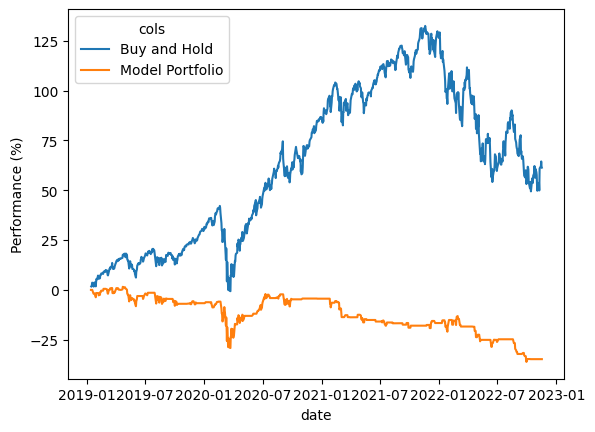

In [265]:
sns.lineplot(data=dfm,x='date',y='Performance (%)',hue='cols',legend='full')

# Save model for deployment

In [266]:
from joblib import dump, load

In [267]:
dump(rfc_final, os.path.join('data','random_forest_classifier.joblib'))

['data/random_forest_classifier.joblib']